# Mini Chinese Input Method Editor with Pinyin Spelling Corrector
## Report Notebook
I was inspired after reading Peter Norvig's chapter in the book, *Beautiful Data* on Natural Language Corpus Data, and subsequently his [implementation](https://norvig.com/spell-correct.html) of a spelling corrector, and I wondered if I could implement a similar spell corrector for pinyin, with the corrected pinyin being used to suggest individual characters, as a primitive Chinese input method editor would do. The syllable (pinyin without tones) and character frequency lists were taken from [Jun Da](http://lingua.mtsu.edu/chinese-computing/) at Middle Tennessee State University. While I am a linguistics minor who is interested in natural language processing, I do not have any significant experience in it besides messing around with NLTK a little bit. I started this project out of curiosity without much expectation, but I figured that nonetheless, it would be an interesting learning experience. I also wanted to use this opportunity to explore how to make Jupyter notebooks more interactive by learning how to use ipywidgets.

The [Repository](https://github.com/rtang18/xiaoshuru):
- [notebooks](https://github.com/rtang18/xiaoshuru/notebooks):
    - [Discovery and Discussion Notebook]("https://github.com/rtang18/xiaoshuru/blob/master/notebooks/Discovery%20and%20Discussion.ipynb"): Includes thought process, exploratory visualizations, first implementations. Good for further contextual reading.
    - Report Notebook (this!): Report outlining the project. My intention is that it can be a Kyso.io blog post.
    - Interface Notebooks: Notebooks with only the IME widgets.
- [scripts](https://github.com/rtang18/xiaoshuru/scripts): Python scripts of the implementation.
- [data](https://github.com/rtang18/xiaoshuru/data): CSV files used.


In [1]:
# Dependencies
# For working with the data
import pandas as pd
# For the wordcloud
import numpy as np
import matplotlib.pyplot as plt
import wordcloud as wc
# To get rid of tone marks
import unidecode
# For interactivity
from ipywidgets import widgets

In [2]:
# Read in data
syllables = pd.read_csv("../data/syllable frequencies.csv")
characters = pd.read_csv("../data/character ranking.csv").dropna()

### Data and Visualizations

Here is the character data. The characters are ranked by frequency.

In [3]:
characters.head()

,frequency_rank,character,pinyin
0,1,的,de
1,2,一,yī
2,3,是,shì
3,4,不,bù
4,5,了,le


Here is the syllables data. The syllables are paired with frequency counts.

In [4]:
syllables.head()

,syllable,frequency
0,a,143836
1,ai,213586
2,an,418511
3,ang,10267
4,ao,60455


Below is a bar plot and a word cloud that shows the most common syllables. We can see that "de" is the most common syllable, followed by "shi" and "yi". Notice how syllables either end in a vowel, "n", or "ng". Compared to English, there are much fewer ways to make a proper syllable, and there are basically no real consonant clusters. (The velar nasal - "ng", the retroflex - "sh", while orthographically appear to consist of two consonants, are actually considered singular phonemes linguistically, as opposed to something like "sk".)

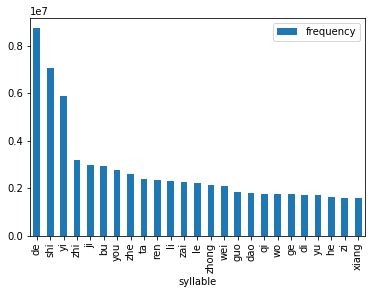

In [6]:
# Bar plot code
syllables.sort_values(by="frequency", axis=0, ascending=False).iloc[0:25, :].plot.bar(x="syllable", y="frequency")
plt.figure(figsize=(12*.75, 8*.75))
plt.show()

In [7]:
from IPython.display import HTML
HTML('<img src="https://raw.githubusercontent.com/rtang18/xiaoshuru/master/notebooks/syllcloud.png">')

Most Chinese IMEs don't differentiate between tones, so we don't either. We add a new column "toneless" which contains the pinyin without tone marks generated using Unidecode.

In [9]:
# Use unidecode to get rid of tone marks, add a new column without tone marks
toneless = np.array([])
for p in characters["pinyin"]:              
    toneless = np.append(toneless, unidecode.unidecode(p))
characters["toneless"] = toneless
characters.head()

,frequency_rank,character,pinyin,toneless
0,1,的,de,de
1,2,一,yī,yi
2,3,是,shì,shi
3,4,不,bù,bu
4,5,了,le,le


Now we can search up all the characters that correspond to any syllable written in toneless pinyin. The intuition behind the IME is that it should ideally retrieve all the characters corresponding to any valid toneless pinyin syllable, like "yi", in order of usage frequency.

For the purposes of the wordcloud and our implementation, we reorganize the dataframes into dictionaries using custom-built functions.

### Spelling Corrector Implementation

On to the spelling corrector! Our implementation is not much different from [Peter Norvig's](https://norvig.com/spell-correct.html). 

The intuition behind it is to:
1. Get all candidates. Candidates include:
    - The input itself if it is a known syllable
    - All known syllables one edit away (deletes, transposes, replaces, inserts)
    - All known syllables two edits away
    - If no known syllables are found using the first three methods, the input itself will be the only candidate returned, so there will be no correction made.
2. Get the probabilities for each candidate, based on relative frequency.
3. Return the candidate with the highest probability as the correction.

All functions functions can be viewed in the [repository](https://github.com/rtang18/xiaoshuru). For more on the process behind the data manipulation and implementation, view the [exploratory notebook](("https://github.com/rtang18/xiaoshuru/blob/master/notebooks/Discovery%20and%20Discussion.ipynb").

Here are the candidates and corrections when "mieo" and "ddu" are inputted:

In [30]:
%run ../scripts/spellingcorrector.py

In [31]:
candidates("mieo")

{'miao', 'mie'}

In [22]:
correction("mieo")

'miao'

In [23]:
candidates("ddu")

{'diu', 'dou', 'du'}

In [24]:
correction("ddu")

'dou'

In [32]:
%run ../scripts/dictionarycontingency.py

We're getting closer to our IME! Here are the top 10 most frequent characters for the corrected version of "ddu", "dou."

In [33]:
hanzi[correction("ddu")][0:10]

['都', '斗', '抖', '豆', '陡', '兜', '逗', '窦', '蚪', '痘']

> When I have more time, I would definitely look into improving the probability calculations. This is already an improvement over some older IMEs that do not tolerate spelling errors well, but I'm still not sure if "dou" is a more realistic choice over "du" if I were to type "ddu". Certainly, the fact that there is a much more limited amount of syllables in Mandarin can be leveraged as well. In the future, I would also look to using Jun Da's bigram frequency data so that the IME can also handle bigrams. As of now, only one character can be processed at a time, and there is no support for special characters like punctuation marks yet either.

### The IME
I don't have a lot of experience in dashboard creation and interactive front-end in general, so I decided to see what I could do with ipywidgets. While IMEs usually need proper GUIs, this year, I'm challenging myself to make more interactive notebooks. So even though this is a really strange use of the widgets to the point where it's almost like a misuse, it's just a fun proof of concept.

There are some limitations. As of now, it handles single characters and automatically outputs the first suggested character. The version below mimics a desktop IME with a select menu. For best results, run the Jupyter Notebook (as opposed to just viewing it on Github/elsewhere).

In [35]:
%run ../scripts/desktopime.py

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Below is a capture of me writing, "你好我是小唐", which means "Hello, I am Little Tang", using the IME.

In [36]:
from IPython.display import HTML
HTML('<img src="https://raw.githubusercontent.com/rtang18/xiaoshuru/master/notebooks/DesktopIME.gif.gif">')